In [ ]:
'''
The goal of this file is:
    1. To present all the components of the capstone project
    2. To be able to load only the trained weights and the video to do so
'''

In [1]:
# O: Import Block

import os
import tensorflow as tf
import numpy as np
import keras
import cv2
import csv
from tqdm.notebook import trange, tqdm
from PIL import Image
from openlocationcode import openlocationcode as olc
import matplotlib.pyplot as plt
from geopy import distance
from ipyleaflet import Map, Marker, AntPath
from ipywidgets import Layout

In [13]:
# 1: Parameters
# TODO: standardize variable names

# https://maps.google.com/pluscodes/support/#why-are-plus-codes-not-sequential-or-incremental
VALID_LABELS = [
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "C",
    "F",
    "G",
    "H",
    "J",
    "M",
    "P",
    "Q",
    "R",
    "V",
    "W",
    "X",
    "NULL",
    "+",
]

FILENAME = "./ocr/SAM_FLIGHT_COMP.mp4"
MODELNAME = 'saved_model/Submission_ML_Model'
VIDEO_FPS = 60
NUM_CHARS = 12 # The number of characters in a Plus Code. 

CHARACTER_WIDTH_WITH_SPACE = 23.5
CHARACTER_WIDTH = 17
# The location in the video where the plus code appears
LEFT_START = 211
TOP = 455
BOTTOM = 482
CHARACTER_HEIGHT = BOTTOM - TOP

# ML Tunables
BATCH_SIZE = 12
VALIDATION_RATIO = 0.3
EPOCHS = 15
MODEL_NAME = "ImpactOCR"
WORKER_COUNT = 8

# Data validation tunables
MAX_REASONABLE_METERS_SEC = 70
MIN_REASONABLE_METERS_SEC = 3

In [3]:
# 2: Helper Block

def distance_meters(a_coordinates, b_coordinates):
    a = (a_coordinates[0], a_coordinates[1])
    b = (b_coordinates[0], b_coordinates[1])
    return distance.distance(a, b).meters



In [4]:
# 3: Data Load Block

# Takes a pre-trained model, and loads it into memory.

submission_model = tf.keras.models.load_model(MODELNAME)
submission_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 27, 17, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 27, 17, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 8, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 8, 16)         1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 4, 32)          4

In [14]:
# 4: Descriptive Data Generation/Non-Descriptive Component

# Descriptive Component: Watches the video, interprets characters, translates into latitude/longitude, and calculates average/max speed based on distance between pins.


# This is where the video is transformed into a manipulable object from it's source.
capture = cv2.VideoCapture(FILENAME)
length_seconds = capture.get(cv2.CAP_PROP_FRAME_COUNT) / VIDEO_FPS

n = 0 # Number of frames polled
found_coordinates = []
invalid_coordinates = []
last_successful_frame_number = 0

total_distance = 0
greatest_speed = 0
least_speed = 100

pbar = tqdm(total=int(length_seconds), desc="Processed", unit=" seconds", position=0)
while True:
    # Capture frames until there are no more frames in the video.
    success, frame = capture.read()
    if not success:
        break

    # Convert from RGB to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    n = n + 1
    # Only pull a frame per second
    if n % VIDEO_FPS != 0:
        continue
    frameImage = Image.fromarray(frame)
    plus_code_images = np.zeros((BATCH_SIZE, CHARACTER_HEIGHT, CHARACTER_WIDTH, 1))
    pbar.update(1)
    for i in range(0, NUM_CHARS):
        left = LEFT_START + (i * CHARACTER_WIDTH_WITH_SPACE)
        right = int(left) + CHARACTER_WIDTH
        cropped = frameImage.crop((int(left), TOP, right, BOTTOM))
        arr = np.asarray(cropped)
        blur = cv2.GaussianBlur(arr, (3, 3), 0)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Morph image to remove noise, and invert image
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        invert = 255 - opening

        im_array = np.asarray(invert)
        finished_image = Image.fromarray(im_array)

        img_array = tf.keras.utils.img_to_array(finished_image)
        plus_code_images[i] = img_array
    model = submission_model
    # Run the model over a batch of BATCH_SIZE images
    result = model.predict(plus_code_images, batch_size=BATCH_SIZE, verbose=0, use_multiprocessing=True, workers=WORKER_COUNT)
    plus_code_characters = []
    for character in result:
        predicted_character = VALID_LABELS[np.argmax(character)]
        if predicted_character == "NULL":
            predicted_character = "?"
        plus_code_characters.append(predicted_character)
    plus_code = "".join(plus_code_characters)
    if olc.isValid(plus_code) and olc.isFull(plus_code):
        latlng = olc.decode(plus_code).latlng()
        
        # Non-Descriptive Component.
        # Because the model only has a 98% success rate, this code predicts what is and is not a valid waypoint for the flight.
        # The if statement permits us to compare the last datapoint to the current datapoint. If the distance between the two points is greater than MAX_REASONABLE_METERS_SEC,
        # we can reasonably assume a character was misinterpreted by the model, but still yielded a valid plus-code. Thus, the point is discarded. 
        if len(found_coordinates) > 0:
            calculated_distance = distance_meters(latlng, found_coordinates[-1])
            # Increase our tolerance to distance jumps when we've lost more frames
            seconds_since_last_successful_frame = (n - last_successful_frame_number) / VIDEO_FPS
            if calculated_distance > MAX_REASONABLE_METERS_SEC * seconds_since_last_successful_frame:
                invalid_coordinates.append(latlng)
                #print(f"{n/60} seconds: REJECTED code {plus_code} - distance={calculated_distance} meters.")
                continue
            found_coordinates.append(latlng)
            #print(f"{n/60} seconds: accepted code {plus_code} - distance={calculated_distance} meters")
            last_successful_frame_number = n
            total_distance = total_distance + calculated_distance
            if calculated_distance / seconds_since_last_successful_frame > greatest_speed and calculated_distance < MAX_REASONABLE_METERS_SEC:
                greatest_speed = calculated_distance / seconds_since_last_successful_frame
            if calculated_distance < least_speed and calculated_distance > MIN_REASONABLE_METERS_SEC:
                least_speed = calculated_distance
        else:
            found_coordinates.append(latlng)
            #print(f"{n/60} seconds: accepted code {plus_code}")
            last_successful_frame_number = n
pbar.close()

Processed:   0%|          | 0/1270 [00:00<?, ? seconds/s]

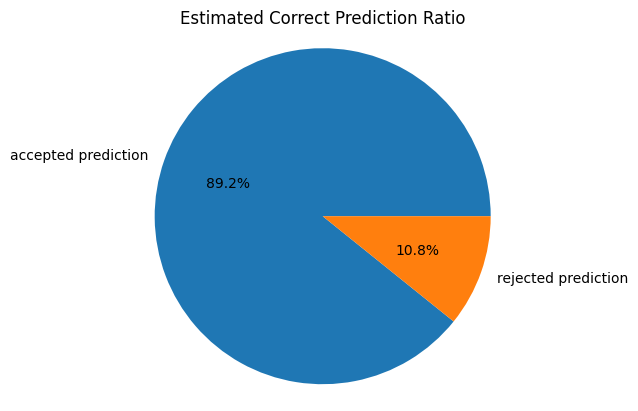

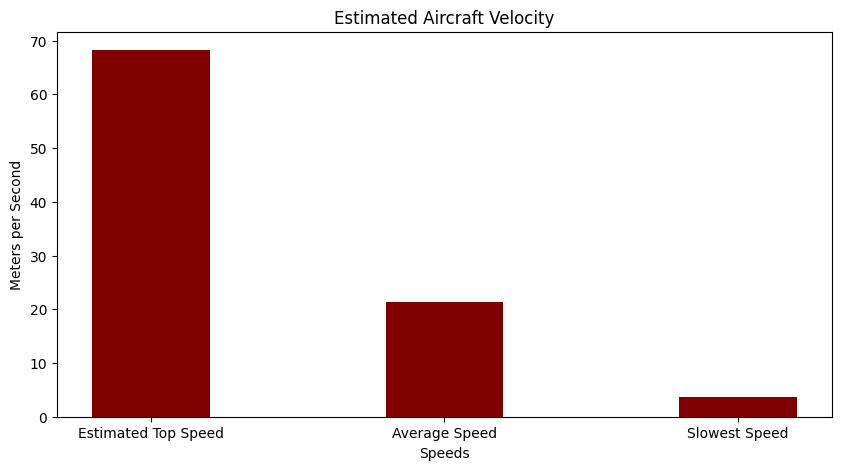

Map(center=[46.1031375, -119.12948437499999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [15]:
# 5:. Display Block

# Provides the 3 visuals.
# 1. A pie chart, with the percentages of correct predictions, vs incorrect predictions.
# 2. Average and Top Speeds for the flight.
# 3. A map of the extracted data.

average_speed = total_distance / (n / VIDEO_FPS)


# Display the prediction pie ratio.
labels = ['accepted prediction', 'rejected prediction']
sizes = [len(found_coordinates), len(invalid_coordinates)]
fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title('Estimated Correct Prediction Ratio')

plt.show()

# Display average and max speed.

data = {'Estimated Top Speed':greatest_speed, 'Average Speed':average_speed, 'Slowest Speed':least_speed}
speeds = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(speeds, values, color ='maroon', width = 0.4)

plt.xlabel("Speeds")
plt.ylabel("Meters per Second")
plt.title("Estimated Aircraft Velocity")
plt.show()

# Show a map of the flight-path.
m = Map(center = found_coordinates[0], 
        zoom = 11, 
        layout=Layout(width='60%', height='500px'))

ant_path = AntPath(locations=found_coordinates, dash_array = [1, 10], delay=2000, color='#7590ba', pulse_color='#3f6fba' )
m.add_layer(ant_path)
display(m)

